## Supplemental Information for _Improved estimates of heritability when genetics and environment are correlated_

> #####Version 0.1
> Microsoft Research, September 17, 2015


This supplement is an IPython notebook that generates synthetic data and illustrates the application of our code to that data.

This notebook allows you to run these analyses on your computer, easily experimenting with different data-generation parameters. If you would like to do this, you need to:

* Install Python and FaST-LMM on your computer: https://github.com/MicrosoftGenomics/FaST-LMM/blob/master/README.md
* Download this IPython notebook from https://github.com/MicrosoftGenomics/FaST-LMM/blob/master/doc/ipynb/heritability_si.ipynb
* Start the IPython notebook from the command line by typing "ipython notebook" and then opening the downloaded notebook. For details see http://jupyter-notebook-beginner-guide.readthedocs.org/en/latest/execute.html

## Preparing the Python Environment and Notebook

Run this cell only if these packages need to be install or updated.

In [ ]:
#Main package
!pip install --upgrade fastlmm

#Needed by this notebook to generate synthetic SNPs
!pip install --upgrade GWAS_benchmark

To prepare this notebook to run analyses, please run the following script.  

In [20]:
# set some ipython notebook properties
%matplotlib inline

# set degree of verbosity (adapt to INFO for more verbose output or debug for info more)
import logging
logging.basicConfig(level=logging.INFO)

# set figure sizes
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# set display width for pandas data frames
import pandas as pd
pd.set_option('display.width', 1000)

## Data Generation

To generate the data, we create SNPs and geo-spatial locations.  We then generate the phenotype from these SNPs and geo-spatial locations. Note that, because the data is synthetic, we know the causal SNPs.  Consequently, we use ${\bf \rm K_{causal}}$ rather than its approximation, ${\bf \rm K_{IBD}}$, in this analysis.

First, we generate 1000 SNPs per individual for 5000 individuals using the Balding-Nichols model for two populations. The populations differ from each other by a FST of 0.1. The heatmap shows the resulting similarity matrix, ${\bf \rm K_{causal}}$, highlighting the existence of two populations.

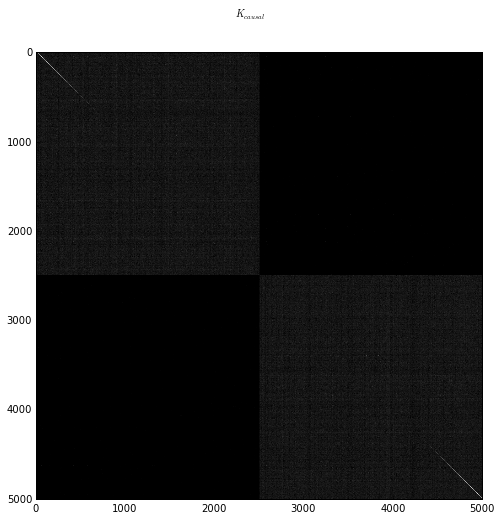

In [34]:
from GWAS_benchmark.snp_gen import snp_gen
import pylab
from pysnptools.standardizer import Unit

seed = 0
N = 5000

#Generate SNPs
snpdata = snp_gen(fst=.1, dfr=0, iid_count=N, sid_count=1000, chr_count=10, label_with_pop=True,seed=seed)
K_causal = snpdata.read_kernel(Unit()).standardize()

pylab.suptitle("$K_{causal}$")
pylab.imshow(K_causal.val, cmap=pylab.gray(), vmin=0, vmax=1)
pylab.show()

Next, we generate a geo-spatial location for each individual by sampling from a two-dimensional Gaussian distribution whose center depends on which population the individual is from.  This creates a correlation between the SNPs and geo-spatial location, and hence an inflated estimate of heritability when left uncorrected.

The plot shows the position of each individual. The two colors reflect the two populations.

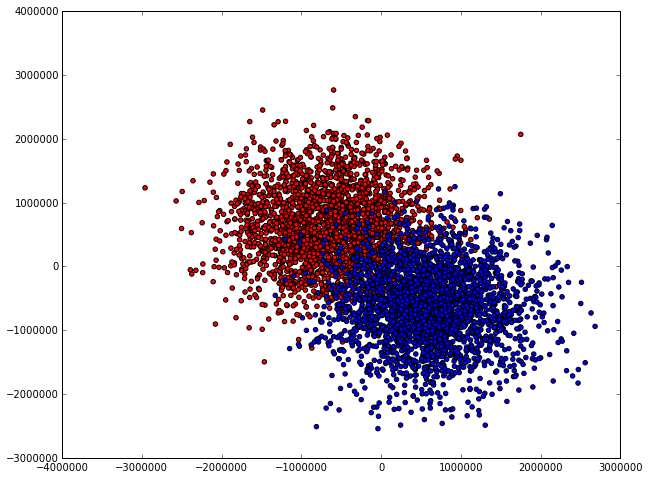

In [27]:
import numpy as np
np.random.seed(seed)
center_dict = {"0": (-1,1), "1": (1,-1)}
spatial_iid = snpdata.iid
centers = np.array([center_dict[iid_item[0]] for iid_item in spatial_iid])
dist_sd =  625000.
spatial_coor = (centers+np.random.multivariate_normal([0,0],[[1,0],[0,1]],size=snpdata.iid_count)) * dist_sd

import matplotlib.pyplot as plt
color_dict = {"0": "r", "1": "b", "2": "g"}
colors = [color_dict[iid_item] for iid_item in snpdata.iid[:,0]]
plt.scatter(spatial_coor[:,0], spatial_coor[:,1], c=colors)
plt.show()

Below is the the similarity matrix ${\rm \bf K}_{\rm loc}$ based on these locations and parameter alpha. ${\rm \bf K}_{{\rm loc}\ {ij}}=e^{-{\rm distance}(i,j)/\alpha}$.

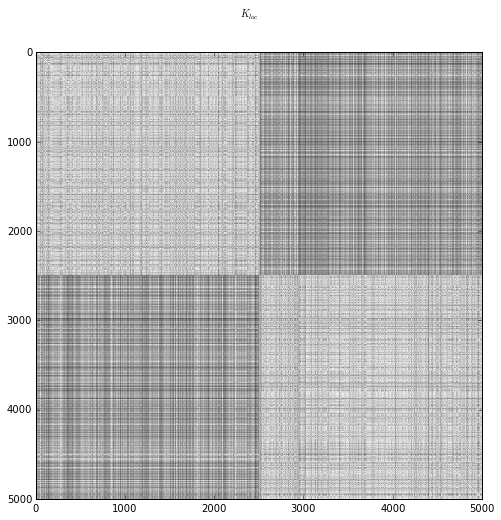

In [28]:
from fastlmm.association.heritability_spatial_correction import spatial_similarity
from pysnptools.kernelreader import KernelData

alpha = 4037017
spatial_val = spatial_similarity(spatial_coor, alpha)
K_loc = KernelData(iid=snpdata.iid,val=spatial_val).standardize()

pylab.suptitle("$K_{loc}$")
pylab.imshow(K_loc.val, cmap=pylab.gray(), vmin=0, vmax=1)
pylab.show()

Finally, we generate the phenotype ${\rm \bf y}$ by sampling from the mixed model ${\rm \bf y} \sim {\bf N}({\bf \mu}; σ_g^2 \  {\bf \rm K_{causal}} + σ_e^2 \ {\bf \rm K_{loc}} + σ_r^2 {\bf \rm I})$. Here, we use ${\bf \mu} = 0$ and $ σ_g^2=σ_e^2=σ_r^2=1/3$.

pop0 mean=-3.15711007497. pop1 mean=-2.30055751891


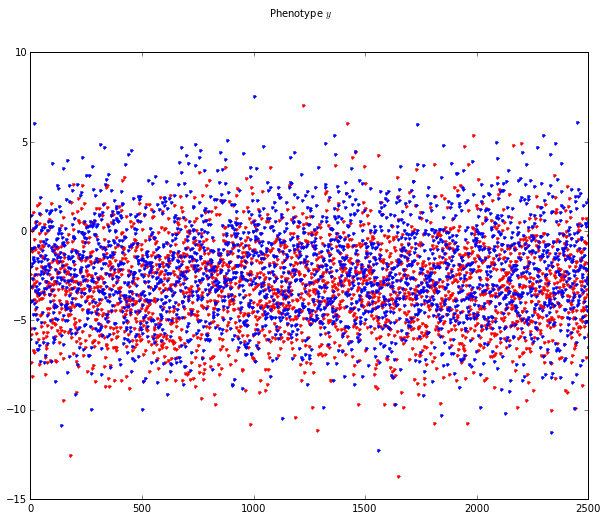

In [31]:
from pysnptools.snpreader import SnpData

np.random.seed(seed)
pheno_val = np.random.multivariate_normal(np.zeros(snpdata.iid_count),
      1./.3 * K_causal.val + 1./.3 * K_loc.val + 1./.3 * np.eye(snpdata.iid_count))
pheno = SnpData(iid=snpdata.iid,sid=["phen0"],val=pheno_val.reshape(-1,1))

is_pop0 = snpdata.iid[:,0]=="0"
is_pop1 = snpdata.iid[:,0]=="1"
print "pop0 mean={0}. pop1 mean={1}".format(pheno_val[is_pop0].mean(),pheno_val[is_pop1].mean())
pylab.suptitle("Phenotype $y$")
plt.plot(range(sum(is_pop0)),pheno_val[is_pop0],"r.",range(sum(is_pop1)),pheno_val[is_pop1],"b.")
plt.show()

## Analysis

Now let us estimate heritabilities using our methodology. The method takes as input  ${\rm \bf K}_{\rm causal}$, geo-spatial location, and phenotype. It searches for the best $\alpha$ and then estimates $σ_g^2, σ_e^2, σ_r^2$ using REML. The Python function that performs the analysis is called 'heritability_spatial_correction'.

Here we loop over multiple random seeds in order to generate and analyze multiple data sets. Python function 'loop_generate_and_analyze' does the looping. It calls 'generate_and_analyze' which generates the data for each seed and calls 'heritability_spatial_correction' to analyze the data.

In [44]:
from GWAS_benchmark.snp_gen import snp_gen
from pysnptools.standardizer import Unit
import numpy as np
from fastlmm.association.heritability_spatial_correction import spatial_similarity
from pysnptools.kernelreader import KernelData
from pysnptools.snpreader import SnpData
from GWAS_benchmark.semisynth_simulations import generate_phenotype
from fastlmm.association import heritability_spatial_correction

def generate_and_analyze(seed, N, just_testing=True, map_function=None, cache_folder=None):

    #Generate SNPs and K_causal
    snpdata = snp_gen(fst=.1, dfr=0, iid_count=N, sid_count=1000, chr_count=10, label_with_pop=True,seed=seed)
    K_causal = snpdata.read_kernel(Unit()).standardize()

    #Generate geo-spatial locations and K_loc
    np.random.seed(seed)
    center_dict = {"0": (-1,1), "1": (1,-1)}
    spatial_iid = snpdata.iid
    centers = np.array([center_dict[iid_item[0]] for iid_item in spatial_iid])
    dist_sd =  625000.
    spatial_coor = (centers+np.random.multivariate_normal([0,0],[[1,0],[0,1]],size=snpdata.iid_count)) * dist_sd
    alpha = 4037017
    spatial_val = spatial_similarity(spatial_coor, alpha)
    K_loc = KernelData(iid=snpdata.iid,val=spatial_val).standardize()

    #Generate phenotype
    np.random.seed(seed)
    pheno_val = np.random.multivariate_normal(np.zeros(snpdata.iid_count),
          1./.3 * K_causal.val + 1./.3 * K_loc.val + 1./.3 * np.eye(snpdata.iid_count))
    pheno = SnpData(iid=snpdata.iid,sid=["phen0"],val=pheno_val.reshape(-1,1))

    #Analyze data
    alpha_list = [int(v) for v in np.logspace(np.log10(100),np.log10(1e10), 100)]
    dataframe = heritability_spatial_correction(
        snpdata,
        spatial_coor,spatial_iid,
        alpha_list=[alpha] if just_testing else alpha_list,pheno=pheno,
        jackknife_count=0,permute_plus_count=0,permute_times_count=0,just_testing=just_testing,
        map_function=map_function,cache_folder=cache_folder)

    logging.info(dataframe)
    return dataframe

def loop_generate_and_analyze(N, seed_count, just_testing, map_function, cache_folder=None):
    '''
    run generate_and_analyze on different seeds
    '''
    df_list = []
    for seed in xrange(seed_count):
        if cache_folder is not None:
            cache_folder_per_seed = cache_folder.format(seed)
        else:
            cache_folder_per_seed = None
        df = generate_and_analyze(seed=seed,N=N,
                           just_testing=just_testing, map_function=map_function, cache_folder=cache_folder_per_seed)
        df_list.append(df)
        
    #format the output dataframe            
    df2 = pd.concat(df_list)
    df2["seed"] = range(seed_count)
    df2["N"]=N
    df3 = df2[["seed","N","alpha","h2corr","e2","h2uncorr"]]
    df3.set_index(["seed"],inplace=True)
    return df3

#### Test Run

To test 'loop_generate_and_analyze', we'll run it first locally with 'N=100' and 'just_testing=True'. With these settings, it should return in just a few seconds, but without meaningful results.

In [51]:
df = loop_generate_and_analyze(N=100,seed_count=7,just_testing=True,map_function=map)
df

,N,alpha,h2corr,e2,h2uncorr
seed,,,,,
0,100,4037017,0,0,0
1,100,4037017,0,0,0
2,100,4037017,0,0,0
3,100,4037017,0,0,0
4,100,4037017,0,0,0
5,100,4037017,0,0,0
6,100,4037017,0,0,0


#### Full Run

The full run with 5000 individuals and 7 seeds requires a cluster. Here we use an Azure HPC cluster, but any cluster that can mimic Python's 'map' function may be used.

In [52]:
#Define a version of 'map' in terms of a cluster
from fastlmm.association.heritability_spatial_correction import work_item
from fastlmm.util import distributed_map
from fastlmm.util.runner import HPC

azure_core_runner_function = lambda taskcount: HPC(min(taskcount,10100), 'GCR',r"\\GCR\Scratch\AZ-USCentral\escience",
                                        remote_python_parent=r"\\GCR\Scratch\AZ-USCentral\escience\carlk\data\carlk\pythonpath",
                                        unit='Core', #Core, Socket, Node
                                        update_remote_python_parent=True,
                                        template="Azure IaaS USCentral",
                                        runtime="0:8:0",
                                        mkl_num_threads=1
                                        )
azure_core_map_function = lambda ignore, arg_list, runner_function=azure_core_runner_function, fn_list=[] : distributed_map.d_map(work_item, arg_list, runner_function(len(arg_list)), fn_list)

#Generate data and analyze it.
df = loop_generate_and_analyze(N=5000,seed_count=7,just_testing=False,
                        map_function=azure_core_map_function,
                        cache_folder=r"D:\data\synth\N5000\seed{0}")
df

,N,alpha,h2corr,e2,h2uncorr
seed,,,,,
0,5000,4037017,0.361689,0.278858,0.453354
1,5000,4862601,0.301393,0.380647,0.411314
2,5000,12328467,0.214872,0.568758,0.409194
3,5000,1592282,0.411140,0.199702,0.453063
4,5000,4037017,0.332356,0.320787,0.454523
5,5000,4862601,0.293746,0.382873,0.410270
6,5000,12328467,0.217819,0.556360,0.446298


Note that the values of h2corr and e2 are consistent with the generating parameters. Also note that h2uncorr is always larger than h2corr.